In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import cv2
import string
import random

In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks

In [14]:
symbols = string.ascii_lowercase + "0123456789" 
num_symbols = len(symbols)
img_shape = (50, 200, 1)
directory_path = '/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples'

In [15]:
print(num_symbols)


36


In [16]:
def create_model():
    img = layers.Input(shape=img_shape) #img input through cn layers
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    #flattening: every branch predicts one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model 
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [17]:
def preprocess_data():
    n_samples = len(os.listdir(directory_path))
    X = np.zeros((n_samples, 50, 200, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i, pic in enumerate(os.listdir(directory_path)):
        
        #skip problematic images
        try:
            # grayscale
            img = cv2.imread(os.path.join(directory_path, pic), cv2.IMREAD_GRAYSCALE)
            pic_target = pic[:-4]
            if len(pic_target) < 6:
                # Scale & reshape image
                img = img / 255.0
                img = np.reshape(img, (50, 200, 1))
                # encode them using OneHotEncoding
                targs = np.zeros((5, num_symbols))
                for j, l in enumerate(pic_target):
                    ind = symbols.find(l)
                    targs[j, ind] = 1
                X[i] = img
                y[:, i] = targs
        except Exception as e:
            print(f"Error processing image {pic}: {str(e)}")
            continue  # Skip this image and continue

    return X, y

In [23]:

X, y = preprocess_data()

X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

for i, pic in enumerate(os.listdir(directory_path)):
    # error handling to skip problematic images
    try:
        img = cv2.imread(os.path.join(directory_path, pic), cv2.IMREAD_GRAYSCALE)
        
        # Check if the image is None - problematic images
        if img is None:
            print(f"Skipping image {pic} because it could not be loaded.")
            continue
        
        pic_target = pic[:-4]
        if len(pic_target) < 6:
                                    # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))

            # targets and encode them using OHEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs

    except Exception as e:
        print(f"Error processing image {pic}: {str(e)}")
        continue  # Skip this image 

Error processing image samples: unsupported operand type(s) for /: 'NoneType' and 'float'
Skipping image samples because it could not be loaded.


In [24]:
model=create_model();
model.summary();

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 50, 200, 16)          160       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 25, 100, 16)          0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d_6[0][0]'

In [25]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], 
                 batch_size=32, epochs=40,verbose=1, validation_split=0.2)

Epoch 1/40
25/25 [==============================] - 2s 66ms/step - loss: 18.1342 - dense_21_loss: 3.6284 - dense_23_loss: 3.6149 - dense_25_loss: 3.6548 - dense_27_loss: 3.6169 - dense_29_loss: 3.6192 - dense_21_accuracy: 0.0515 - dense_23_accuracy: 0.0528 - dense_25_accuracy: 0.0425 - dense_27_accuracy: 0.0528 - dense_29_accuracy: 0.0490 - val_loss: 17.7175 - val_dense_21_loss: 3.6128 - val_dense_23_loss: 3.4618 - val_dense_25_loss: 3.5315 - val_dense_27_loss: 3.5251 - val_dense_29_loss: 3.5863 - val_dense_21_accuracy: 0.0515 - val_dense_23_accuracy: 0.0567 - val_dense_25_accuracy: 0.0515 - val_dense_27_accuracy: 0.0722 - val_dense_29_accuracy: 0.0000e+00
Epoch 2/40
25/25 [==============================] - 2s 86ms/step - loss: 17.0957 - dense_21_loss: 3.4005 - dense_23_loss: 3.3647 - dense_25_loss: 3.4638 - dense_27_loss: 3.4068 - dense_29_loss: 3.4599 - dense_21_accuracy: 0.0567 - dense_23_accuracy: 0.0760 - dense_25_accuracy: 0.0644 - dense_27_accuracy: 0.0464 - dense_29_accuracy: 0

In [34]:
#saving the model:

model.save("/Users/maymay/Desktop/CSDF MIMNI PROJEKT/templates/captcha_model.hdf5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt

In [28]:
score = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], verbose=1)

print("\n\t", score)

4/4 [==============================] - 0s 12ms/step - loss: 1.7111 - dense_21_loss: 0.1281 - dense_23_loss: 0.2846 - dense_25_loss: 0.4622 - dense_27_loss: 0.5046 - dense_29_loss: 0.3315 - dense_21_accuracy: 0.9703 - dense_23_accuracy: 0.9505 - dense_25_accuracy: 0.8812 - dense_27_accuracy: 0.8218 - dense_29_accuracy: 0.9208

	 [1.7110636234283447, 0.1281481385231018, 0.2846260666847229, 0.46224087476730347, 0.5045525431632996, 0.3314960300922394, 0.9702970385551453, 0.9504950642585754, 0.8811880946159363, 0.8217821717262268, 0.9207921028137207]


In [33]:
model_save

'/Users/maymay/Desktop/CSDF MIMNI PROJEKT/templates/captcha_model.hdf5'

In [29]:
#chechking the models:
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/8n5p3.png'))
print(predict('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/f2m8n.png'))
print(predict('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/dce8y.png'))
print(predict('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/3eny7.png'))
print(predict('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/npxb7.png'))

1/1 [==============================] - 0s 110ms/step
6n5p3
1/1 [==============================] - 0s 15ms/step
f2m8n
1/1 [==============================] - 0s 24ms/step
dce8y
1/1 [==============================] - 0s 14ms/step
3eny7
1/1 [==============================] - 0s 14ms/step
npxb7


In [30]:
img=cv2.imread('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/a.png',cv2.IMREAD_GRAYSCALE)

if img is not None:  # loaded successfully
    # Ensure the image data is in a compatible data type (e.g., float or uint8)
    img = img.astype(np.float32)  # Convert to float32
    # Alternatively, you can use: img = img.astype(np.uint8)  # Convert to uint8

    # Display the image
    plt.imshow(img, cmap='gray')
    plt.show()
else:
    print("Image could not be loaded.")

Image could not be loaded.


[ WARN:0@989.192] global loadsave.cpp:248 findDecoder imread_('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples/a.png'): can't open/read file: check file path/integrity


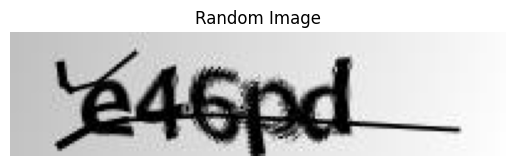

In [31]:
image_files = [file for file in os.listdir('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples') if file.endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print("No image files found in the directory.")
else:
    # Choose a random image file
    random_image_file = random.choice(image_files)
    
    captcha_text = random_image_file[:-4]  # Assuming the text is in the filename without the extension
    
    # Load and display the random image
    random_image_path = os.path.join('/Volumes/This One Is Totally Infectious/CSDF MIMNI PROJEKT/samples', random_image_file)
    random_image = cv2.imread(random_image_path, cv2.IMREAD_COLOR)  # Change the flag if needed
    if random_image is not None:
        plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.title("Random Image")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to load the random image.")

In [32]:
captcha_text

'e46pd'